In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
url = "https://raw.githubusercontent.com/DnyanaBhamare09/Data/main/Apple_share_price_prediction.csv"

In [3]:
df = pd.read_csv(url)

In [4]:
df.head()

,Unnamed: 0,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,0,AAPL,2015-05-27 00:00:00+00:00,132.045,132.260,130.05,130.34,45833246,121.682558,121.880685,119.844118,120.111360,45833246,0.0,1.0
1,1,AAPL,2015-05-28 00:00:00+00:00,131.780,131.950,131.10,131.86,30733309,121.438354,121.595013,120.811718,121.512076,30733309,0.0,1.0
2,2,AAPL,2015-05-29 00:00:00+00:00,130.280,131.450,129.90,131.23,50884452,120.056069,121.134251,119.705890,120.931516,50884452,0.0,1.0
3,3,AAPL,2015-06-01 00:00:00+00:00,130.535,131.390,130.05,131.20,32112797,120.291057,121.078960,119.844118,120.903870,32112797,0.0,1.0
4,4,AAPL,2015-06-02 00:00:00+00:00,129.960,130.655,129.32,129.86,33667627,119.761181,120.401640,119.171406,119.669029,33667627,0.0,1.0


In [5]:
df1 = df.reset_index()["close"]

In [6]:
df1

0       132.045
1       131.780
2       130.280
3       130.535
4       129.960
         ...   
1253    314.960
1254    313.140
1255    319.230
1256    316.850
1257    318.890
Name: close, Length: 1258, dtype: float64

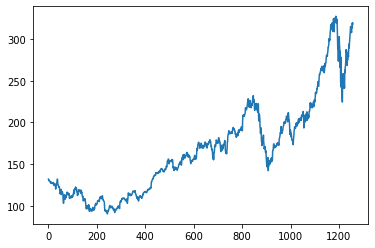

In [7]:
plt.plot(df1)

In [8]:
# Scaling the data as LSTM is sensitive to scale of the data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range =(0, 1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))

In [9]:
print(df1)

[[0.17607447]
 [0.17495567]
 [0.16862282]
 ...
 [0.96635143]
 [0.9563033 ]
 [0.96491598]]


In [10]:
# train test split
training_size = int(len(df1)*0.65)
test_size = len(df1) - training_size
train_data, test_data = df1[0:training_size, :], df1[training_size:len(df1), :1]

In [11]:
training_size, test_size

(817, 441)

# Preprocessing for time series values

In [16]:
def create_dataset(dataset, time_step = 1):
  dataX, dataY = [], []
  for i in range(len(dataset)-time_step-1):
    a = dataset[i:(i+time_step), 0]
    dataX.append(a)
    dataY.append(dataset[i + time_step, 0])
  return np.array(dataX), np.array(dataY)

In [17]:
# Get training and testing dataset
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [18]:
print(X_train.shape), print(y_train.shape)

(716, 100)
(716,)


(None, None)

In [20]:
print(X_test.shape), print(y_test.shape)

(340, 100)
(340,)


(None, None)

# Reshaping the input as per LSTM

In [22]:
# Reshaping the input as [samples, time_steps, features] as required by LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Creating LSTM model

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [26]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (100, 1)))
model.add(LSTM(50, return_sequences = True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss = "mean_squared_error", optimizer = "adam")

In [27]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100, 50)           10400     
_________________________________________________________________
lstm_2 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [28]:
model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 100, batch_size =64, verbose = 1)

Epoch 1/100
12/12 [==============================] - 35s 196ms/step - loss: 0.0270 - val_loss: 0.0763
Epoch 2/100
12/12 [==============================] - 1s 85ms/step - loss: 0.0051 - val_loss: 0.0049
Epoch 3/100
12/12 [==============================] - 1s 87ms/step - loss: 0.0012 - val_loss: 0.0042
Epoch 4/100
12/12 [==============================] - 1s 84ms/step - loss: 8.1089e-04 - val_loss: 0.0060
Epoch 5/100
12/12 [==============================] - 1s 85ms/step - loss: 7.0800e-04 - val_loss: 0.0073
Epoch 6/100
12/12 [==============================] - 1s 86ms/step - loss: 6.4416e-04 - val_loss: 0.0068
Epoch 7/100
12/12 [==============================] - 1s 85ms/step - loss: 6.7491e-04 - val_loss: 0.0058
Epoch 8/100
12/12 [==============================] - 1s 85ms/step - loss: 6.4468e-04 - val_loss: 0.0053
Epoch 9/100
12/12 [==============================] - 1s 86ms/step - loss: 6.2051e-04 - val_loss: 0.0045
Epoch 10/100
12/12 [==============================] - 1s 86ms/step - loss:

In [29]:
# Predictions and performance metrics
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

In [30]:
# Transform back to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [31]:
# Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train, train_predict))

143.86496945004083

In [32]:
math.sqrt(mean_squared_error(y_test, test_predict))

240.71175420503587

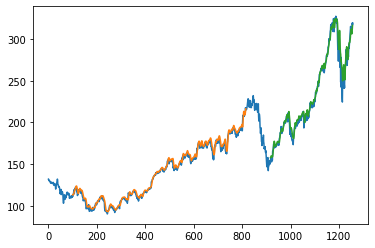

In [34]:
# Plot representation
look_back = 100
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:,:] = np.nan
trainPredictPlot[look_back:len(train_predict) + look_back, :] = train_predict

# test prediction for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict

# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()


# Predicting the values for next 30 days

In [38]:
# we find the shape of test data
len(test_data)

441

In [39]:
# First we take a test data of previous 100 days
x_input = test_data[341:].reshape(1, -1)
x_input.shape

(1, 100)

In [40]:
# convert input data into the list
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

In [41]:
# Predictiing the output for next 30 days
from numpy import array

lst_output=[]   # empty list of the output
n_steps=100
i=0
while(i<30):        # 30 shows next 30 days
    
    if(len(temp_input)>100):                         # As input data is 100. So we are shifting input by 1 position
        #print(temp_input)
        x_input=np.array(temp_input[1:])             # take input by shifting it by 1 place. We continue this till we reach i = 30 i.e 30 days predictions
        print("{} day input {}".format(i,x_input))    
        x_input=x_input.reshape(1,-1)                # reshaping the input accoriding to LSTM
        x_input = x_input.reshape((1, n_steps, 1))   
           
        yhat = model.predict(x_input, verbose=0)     # predicting the output
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())          # add output to input list by extending the input list
        temp_input=temp_input[1:]
        
        lst_output.extend(yhat.tolist())             
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    
print(lst_output)

[0.9652145]
101
1 day input [0.8866419  0.87431394 0.88431985 0.87836697 0.8986321  0.92582116
 0.92877649 0.95676771 0.93869797 0.93304061 0.94950604 0.96424048
 0.95512117 0.95989192 0.96635143 0.96246728 0.92295027 0.9598497
 0.98792536 0.98594106 0.92531453 0.92172591 0.96474711 0.97572406
 0.99159841 0.96972895 0.97614625 0.96795575 1.         0.99016297
 0.99050072 0.96538039 0.98488559 0.97086887 0.94026007 0.87748037
 0.83483915 0.85413324 0.77336823 0.77269273 0.88014017 0.84007431
 0.89673225 0.85527316 0.83884995 0.74233725 0.82327113 0.78143207
 0.6665963  0.7921557  0.64118044 0.68614371 0.66001013 0.65203074
 0.58642236 0.56586169 0.66089673 0.65515494 0.70970193 0.66452757
 0.69437642 0.69218104 0.63569197 0.65266402 0.63780292 0.7267162
 0.71388162 0.74191506 0.75002111 0.77222832 0.83049059 0.8194292
 0.8289707  0.8125475  0.78776492 0.75162543 0.78426074 0.77974331
 0.81326522 0.8141096  0.79473106 0.83336148 0.85898843 0.83901883
 0.85628641 0.87486279 0.88782403 0.9

In [42]:
# Getting arrays for days
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

In [43]:
len(df1)

1258

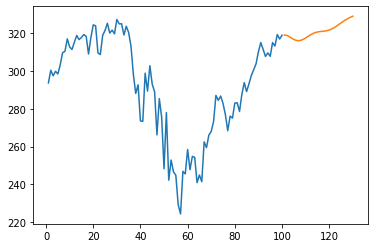

In [44]:
plt.plot(day_new,scaler.inverse_transform(df1[1158:]))   # old days
plt.plot(day_pred,scaler.inverse_transform(lst_output))  # new days